# NLP-LAB Exercise 01 by jonas weinz
----

In [1]:
%matplotlib inline 
#inline for publishing on github. For jupyter lab set ipympl here

import nltk
import pprint
#from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

* download data

In [2]:
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package treebank to /home/jonas/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /home/jonas/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jonas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/jonas/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

## implementing own classifiers

* writing an own feature funtion

In [3]:
def features(sentence, index):
    word = sentence[index]
    is_punctuation_mark = word == "!" or word == "." or word == "," or word == "?"
    sentence_length = len(sentence)
    relative_third = (index * 3) // sentence_length 
    vowels = word.count('a') + word.count('e') + word.count('i') + word.count('o') + word.count('u')
    return {
        'word': word,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'prefix-1': sentence[index][0],
        'suffix-1': sentence[index][-1],
        'prefix-2': sentence[index][1] if len(word) > 1 else '',
        'suffix-2': sentence[index][-2] if len(word) > 1 else '',
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'length': len(word),
        'index' : index,
        'rev_index': len(sentence) - index,
        'sentence_length_': len(sentence),
        'relative_third': relative_third,
        'numerical': word.isnumeric(),
        'is_punctuation_mark': is_punctuation_mark,
        ',': word == ",",
        '.': word == ".",
        '!': word == "!",
        '?': word == "?",
        'vowels' : vowels
    }

In [4]:
#test_sentence = ['The','cake','is','a','lie','!']
#for i in range(len(test_sentence)):
#    pprint.pprint(features(test_sentence, i))

* function for creating training sets

In [5]:
def untag(tagged_sentence):
    return [w for w,t in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    X,y = [], []
    
    for s in tagged_sentences:
        for i in range(len(s)):
            X.append(features(untag(s),i))
            y.append(s[i][1])
    return X,y

def create_training_and_test_set(annotated_sentences, relative_cutoff):
    cutoff = int(relative_cutoff * len(annotated_sentences))
    training_sentences = annotated_sentences[:cutoff]
    test_sentences = annotated_sentences[cutoff:]
    
    X,y = transform_to_dataset(training_sentences)
    tX, ty = transform_to_dataset(test_sentences)
    
    return X,y,tX,ty

* Train classifier

In [6]:
def train_classifier(X,y,classifier,max_size=10000):
    clf = Pipeline([
        ('vectorizer', DictVectorizer(sparse=False)),
        ('classifier', classifier)
    ])
    
    print("start training…")
    
    clf.fit(
        X if len(X) < max_size else X[:max_size],
        y if len(y) < max_size else y[:max_size]
    )
    
    print("training done")
    
    return clf

* classifier evaluater

In [7]:
def test_classifier(clf, tX, ty):
    accuracy = clf.score(tX, ty)
    print("Accuracy: ", accuracy)
    # TODO: more analytics
    return accuracy

## Task 01:

### Performance 1


#### Model 01
* train and testing english custom POS tagger model:

In [8]:
def model_01(X,y,tX,ty, max_size=10000):
    #classifier = DecisionTreeClassifier(criterion='entropy')
    model01_clf = train_classifier(X,y,MLPClassifier(hidden_layer_sizes=(100,), learning_rate='adaptive'),max_size=max_size)
    return test_classifier(clf=model01_clf, tX=tX, ty=ty)

#### Model 02

In [9]:
def model_02(tX,ty):
    m2_y = nltk.pos_tag([w['word'] for w in tX])
    # compare results
    n_correct = sum((1 if m2_y[i][1] == ty[i] else 0) for i in range(len(ty)))
    return n_correct / len(ty)

#### Model 03

In [10]:
def model_03(corpus_tagged, corpus_sents, cut=0.8):
    
    patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
             (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]
    
    s = int(len(corpus_tagged) * cut)
    train_sents = corpus_tagged[:s]
    test_sents = corpus_tagged[s:]
    
    models = {
        'def_model': nltk.DefaultTagger('NN'),
        'regexp_model': nltk.RegexpTagger(patterns),
        'uni_model': nltk.UnigramTagger(train_sents),
        'bi_model': nltk.BigramTagger(train_sents),
        'tri_model': nltk.TrigramTagger(train_sents)
    }
    
    performance = {}
    for name,model in models.items():
        performance[name] = model.evaluate(test_sents)
    
    return performance


### Applying models on Datasets

In [11]:
# dictionary containing all performances
performances = {}

treebank_tagged = nltk.corpus.treebank.tagged_sents()
treebank_sents = nltk.corpus.treebank.sents()

brown_tagged = nltk.corpus.brown.tagged_sents(categories='news')
brown_sents = nltk.corpus.brown.sents(categories='news')

#display(treebank_tagged[0])

X1,y1,tX1,ty1 = create_training_and_test_set(annotated_sentences=treebank_tagged, 
                                         relative_cutoff=0.8)

X2,y2,tX2,ty2 = create_training_and_test_set(annotated_sentences=brown_tagged, 
                                         relative_cutoff=0.8)


# running performances 1.1 - 1.6

print("P1.1")
performances['P1.1'] = model_01(X1,y1,tX1,ty1)

print("P1.2")
performances['P1.2'] = model_02(tX1,ty1)

print("P1.3")
p3 = model_03(treebank_tagged, treebank_sents)
for k,v in p3.items():
    performances["P1.3 -- " + k] = v

print("P1.4")
performances['P1.4'] = model_01(X2,y2,tX2,ty2)

print("P1.5")
performances['P1.5'] = model_02(tX2,ty2)

print("P1.6")
p6 = model_03(brown_tagged, brown_sents)
for k,v in p6.items():
    performances["P1.6 -- " + k] = v

    
print("\nAll Performances:")
pprint.pprint(performances)


P1.1
start training…
training done
Accuracy:  0.9156644543140875
P1.2
P1.3
P1.4
start training…
training done
Accuracy:  0.8418517269617997
P1.5
P1.6

All Performances:
{'P1.1': 0.9156644543140875,
 'P1.2': 0.8936074654423873,
 'P1.3 -- bi_model': 0.1132791057437996,
 'P1.3 -- def_model': 0.1447677029791906,
 'P1.3 -- regexp_model': 0.24232746145017217,
 'P1.3 -- tri_model': 0.06736863116922003,
 'P1.3 -- uni_model': 0.8608213982733669,
 'P1.4': 0.8418517269617997,
 'P1.5': 0.615540247603449,
 'P1.6 -- bi_model': 0.09186376993111421,
 'P1.6 -- def_model': 0.1209595837949805,
 'P1.6 -- regexp_model': 0.19683029047641987,
 'P1.6 -- tri_model': 0.05867334650031312,
 'P1.6 -- uni_model': 0.8026879907509996}


### Plotting Data

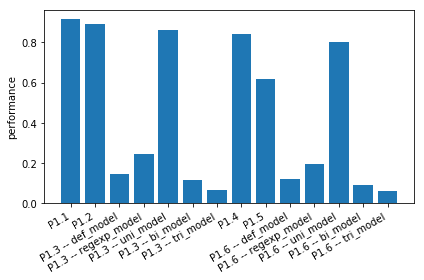

In [26]:
import matplotlib.pyplot as plt
import numpy as np
#weights = clf.named_steps['classifier'].feature_importances_
#labels = clf.named_steps['vectorizer'].get_feature_names()

#sort
#weights, labels = (list(t) for t in zip(*sorted(zip(weights, labels))))

fig_1, ax_1 = plt.subplots()
plt.bar(np.arange(len(performances)), performances.values())
plt.xticks(np.arange(len(performances)), performances.keys(), rotation=30, ha='right')
plt.ylabel("performance")
plt.tight_layout()
plt.show()


----
## Task 2

* the file `ru_syntagrus-ud-train-uncommented.conllu` is generated from the file `ru_syntagrus-ud-train.conllu` located here: https://github.com/UniversalDependencies/UD_Russian-SynTagRus. Changes to the original file:
    * removed commentaries (lines with leading `#`)
    * removed spaces in in long numbers (eg: `100 000` → `100000`)

In [13]:
WORDS = 'words'   #: column type for words
POS = 'pos'       #: column type for part-of-speech tags
TREE = 'tree'     #: column type for parse trees
CHUNK = 'chunk'   #: column type for chunk structures
NE = 'ne'         #: column type for named entities
SRL = 'srl'       #: column type for semantic role labels
IGNORE = 'ignore' #: column type for column that should be ignored
ru_corp = nltk.corpus.ConllCorpusReader(root="./", 
                              fileids=["ru_syntagrus-ud-train-uncommented.conllu"],
                              columntypes=[IGNORE, WORDS, IGNORE, POS],
                                       encoding='utf-8')


In [14]:
ru_tagged = ru_corp.tagged_sents()



X3,y3,tX3,ty3 = create_training_and_test_set(annotated_sentences=ru_tagged, 
                                         relative_cutoff=0.8)


#### Model 04, Performance 2.1

In [15]:
print("P2.1")
performances2 = {}
performances2['P2.1'] = model_01(X3,y3,tX3,ty3, max_size=5000) # 10000 here consumes too much memory on my laptop
print(performances2['P2.1'])

P2.1
start training…
training done
Accuracy:  0.7951261788284127
0.7951261788284127


#### Model 05, Performance 2.2

In [16]:
# write russian text out to file:
f = open("ru_text.txt", 'w')
for word_features in tX3:
    f.write(word_features['word'] + " ")
    if word_features['word'] == '.':    
        f.write("\n") #new sentence → new line
f.close()

* download the python 3 fork of the rdrpos-tagger: https://github.com/jacopofar/RDRPOSTagger-python-3
    ```
    mkdir -p ~/src
    cd ~/src
    git clone https://github.com/jacopofar/RDRPOSTagger-python-3.git
    ```
* adjust `RDRPOS_TAGGER_PATH` to match with the download location

In [17]:
import sys, os

# remember current working directory
cwd = os.getcwd()

In [18]:
RDRPOS_TAGGER_PATH = os.environ['HOME'] + "/src/RDRPOSTagger-python-3/pSCRDRtagger/"

sys.path.insert(0, RDRPOS_TAGGER_PATH)

# change current working directory to RDRPOSTagger repo
os.chdir(RDRPOS_TAGGER_PATH)

import RDRPOSTagger as model05_tagger 

# train tagger (copied from RDRPOSTagger.py):
r = model05_tagger.RDRPOSTagger()
r.constructSCRDRtreeFromRDRfile("../Models/UniPOS/UD_Russian-SynTagRus/train.UniPOS.RDR")
DICT = model05_tagger.readDictionary("../Models/UniPOS/UD_Russian-SynTagRus/train.UniPOS.DICT")

# change back to our cwd
os.chdir(cwd)

# run trained tagger
r.tagRawCorpus(DICT, "ru_text.txt")

['Node', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'tabStr']
('\nOutput file:', 'ru_text.txt.TAGGED')


In [19]:
tagged_words = []
f = open("ru_text.txt.TAGGED", 'r')
for line in f:
    for splits in line.split():
        w,t = splits.rsplit('/',1) # use last occurence of '/' to split.
        tagged_words.append((w,t))


In [20]:
score_2_2 = sum((1 if tagged_words[i][1] == ty3[i] else 0)for i in range(len(tagged_words))) / len(tagged_words)
performances2['P2.2'] = score_2_2


## Results of performance 2

In [21]:
pprint.pprint(performances2)

{'P2.1': 0.7951261788284127, 'P2.2': 0.8884973715119793}


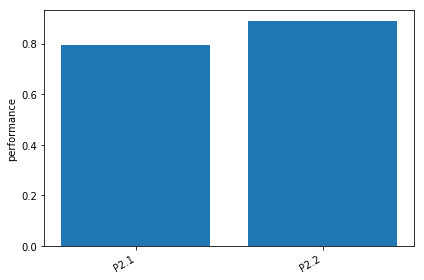

In [27]:
fig_2, ax_2 = plt.subplots()
plt.bar(np.arange(len(performances2)), performances2.values())
plt.xticks(np.arange(len(performances2)), performances2.keys(), rotation=30, ha='right')
plt.ylabel("performance")
plt.tight_layout()
plt.show()
